In [67]:
import pandas as pd
import geopandas as gpd
import folium
import matplotlib.pyplot as plt
import json
import numpy as np
import itertools
from scipy.stats import gaussian_kde
from shapely.geometry import Point
from shapely.geometry import Polygon

In [2]:
crime_gdf = gpd.read_file("./geojson/aichi-crime-2020.geojson")
print(len(crime_gdf))

45456


In [3]:
# 信頼度0.8以上に限定
crime_gdf = crime_gdf[crime_gdf["relevance"] > 0.8]
print(len(crime_gdf))

39351


In [4]:
# 直交座標系に変換
crime_gdf = crime_gdf.to_crs(6675)

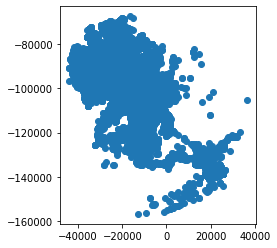

In [5]:
crime_gdf[crime_gdf["relevance"] > 0.8].plot()

## サンプルデータでカーネル密度推定

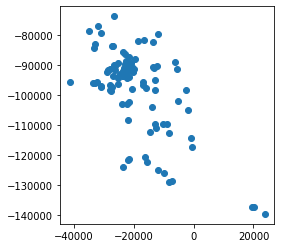

In [6]:
# サンプルを抽出(n=100)
n_sample = 100
sample_gdf = crime_gdf.sample(n_sample)
#display(sample_gdf)
sample_gdf.plot()

In [7]:
# 2次元配列に反感
coord_list= []
for g in sample_gdf["geometry"].values:
    coord_list.append(list(g.coords)[0])

coord_list = np.array(coord_list)
coord_list = np.transpose(coord_list)

print(coord_list.shape)

(2, 100)


In [8]:
# カーネル密度推定
bw_method = "scott"
#bw_method = "silverman"

kde = gaussian_kde(coord_list, bw_method=bw_method)

In [9]:
# 任意のデータを外挿
target_geometry = np.array([(0, 0), (1000, 1000), (-20000, -90000)])
target_geometry = np.transpose(target_geometry)
print(target_geometry.shape)
kde.evaluate(target_geometry)

(2, 3)


array([1.04630966e-83, 7.35352333e-87, 1.60306227e-09])

## 全データでカーネル密度推定

In [10]:
# 2次元配列に反感
coord_list= []
for g in crime_gdf["geometry"].values:
    coord_list.append(list(g.coords)[0])

coord_list = np.array(coord_list)
coord_list = np.transpose(coord_list)

print(coord_list.shape)

(2, 39351)


In [11]:
# カーネル密度推定
bw_method = "scott"
#bw_method = "silverman"

kde = gaussian_kde(coord_list, bw_method=bw_method)

In [12]:
# 任意のデータを外挿
target_geometry = np.array([(0, 0), (1000, 1000), (-20000, -90000)])
target_geometry = np.transpose(target_geometry)
print(target_geometry.shape)
kde.evaluate(target_geometry)

(2, 3)


array([0.0000000e+00, 0.0000000e+00, 1.9002447e-09])

## ヒートマップの生成

In [52]:
n_split = 100 # 1000x1000に分割
min_x = np.min(coord_list[0])
max_x = np.max(coord_list[0])
min_y = np.min(coord_list[1])
max_y = np.max(coord_list[1])
x_range = np.linspace(min_x, max_x, n_split)
y_range = np.linspace(min_y, max_y, n_split)

target_geometry = []
for x, y in itertools.product(x_range, y_range):
    target_geometry.append((x, y))

target_geometry = np.array(target_geometry)
target_geometry = np.transpose(target_geometry)
    
print(target_geometry.shape)

(2, 10000)


In [53]:
density_list = kde.evaluate(target_geometry)
print(len(density_list))

10000


In [54]:
target_geometry = np.transpose(target_geometry)
print(target_geometry.shape)

(10000, 2)


In [92]:
# GeoJSONに変換
geojson = {
    "type": "FeatureCollection",
    "features": []
}

# ポリゴンの1辺の距離
length_x = np.abs(x_range[1] - x_range[0])
length_y = np.abs(y_range[1] - y_range[0])
radius_x = length_x / 2
radius_y = length_y / 2
print(f"length_x={length_x} length_y={length_y}")

features = []
for (x,y),density in zip(target_geometry, density_list):
    #print(f"{x} {y} {density}")

    feature = {
        "type": "Feature",
        "geometry": {
            "type": "Polygon",
            "coordinates": [[[x-radius_x,  y-radius_y],[x+radius_x, y-radius_y],[x+radius_x, y+radius_y],[x-radius_x,  y+radius_y],[x-radius_x,  y-radius_y]]],
        },
        "properties": {
            "density": density,
        }
    }
    
    features.append(feature)
    
geojson["features"] = features
print(geojson["features"][0])

length_x=814.7826140213074 length_y=904.5823187090282
{'type': 'Feature', 'geometry': {'type': 'Polygon', 'coordinates': [[[-44467.36786963405, -157329.25330070395], [-43652.585255612736, -157329.25330070395], [-43652.585255612736, -156424.6709819949], [-44467.36786963405, -156424.6709819949], [-44467.36786963405, -157329.25330070395]]]}, 'properties': {'density': 1.4989612720206684e-98}}


In [93]:
# GeoJSONファイルを書込
with open("./geojson/crime-density-2020.geojson", "w") as f:
    json.dump(geojson, f, ensure_ascii=False)

In [98]:
density_gdf = gpd.read_file("./geojson/crime-density-2020.geojson")
print(len(density_gdf))
display(density_gdf)

10000


,density,geometry
0,1.498961e-98,"POLYGON ((-44467.36787 -157329.25330, -43652.5..."
1,8.709786e-95,"POLYGON ((-44467.36787 -156424.67098, -43652.5..."
2,4.734890e-91,"POLYGON ((-44467.36787 -155520.08866, -43652.5..."
3,2.067897e-87,"POLYGON ((-44467.36787 -154615.50634, -43652.5..."
4,7.149516e-84,"POLYGON ((-44467.36787 -153710.92403, -43652.5..."
...,...,...
9995,4.181931e-87,"POLYGON ((36196.11092 -71393.93302, 37010.8935..."
9996,4.713197e-91,"POLYGON ((36196.11092 -70489.35070, 37010.8935..."
9997,4.199330e-95,"POLYGON ((36196.11092 -69584.76839, 37010.8935..."
9998,2.957810e-99,"POLYGON ((36196.11092 -68680.18607, 37010.8935..."


In [101]:
# 緯度軽度に変換
density_gdf = density_gdf.to_crs(4326)
display(density_gdf)

,density,geometry
0,1.498961e-98,"POLYGON ((-44467.36787 -157329.25330, -43652.5..."
1,8.709786e-95,"POLYGON ((-44467.36787 -156424.67098, -43652.5..."
2,4.734890e-91,"POLYGON ((-44467.36787 -155520.08866, -43652.5..."
3,2.067897e-87,"POLYGON ((-44467.36787 -154615.50634, -43652.5..."
4,7.149516e-84,"POLYGON ((-44467.36787 -153710.92403, -43652.5..."
...,...,...
9995,4.181931e-87,"POLYGON ((36196.11092 -71393.93302, 37010.8935..."
9996,4.713197e-91,"POLYGON ((36196.11092 -70489.35070, 37010.8935..."
9997,4.199330e-95,"POLYGON ((36196.11092 -69584.76839, 37010.8935..."
9998,2.957810e-99,"POLYGON ((36196.11092 -68680.18607, 37010.8935..."
